<a href="https://colab.research.google.com/github/spcnz/image-captioning/blob/main/image_captioning_RESNET_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt

import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

!nvidia-smi

Fri Apr 14 13:07:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |    627MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download dataset from kaggle


In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"milenalaketic","key":"46a3339b945bfda86a00d9e13708299e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
! unzip /content/flickr8k.zip -d flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/Images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/Images/2849194983_2968c72832.jpg  
  inflating: flickr8k/Images/28507194

# Display data

In [5]:
pd.set_option('display.max_columns', None)  

image_path = './flickr8k/Images'
data = pd.read_csv("./flickr8k/captions.txt")
data.head()



image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [6]:
# data = data.sample(15)

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.rcParams['font.size'] = 8

def readImage(path, img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img / 255.
    
    return img
    
def display_images(temp_df, image_num):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(image_num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        title = "\n".join(wrap(temp_df.caption[i], 20))
        plt.title(title)
        plt.axis("off")

In [8]:
plt.rcParams['font.size'] = 10

def display_results(temp_df, image_num):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(image_num):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"./flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        caption = "\n".join(wrap(temp_df.caption[i][8:-6], 30))
        predicted = "\n".join(wrap(temp_df.generated_caption[i][8:-6], 30))
        bleu = '\nBLEU:{:.4f}'.format(temp_df.bleu[i])

        plt.text(0, 0 , caption + "\n\nPredicted: " + predicted + "\n" + bleu + "\n")
        plt.axis("off")


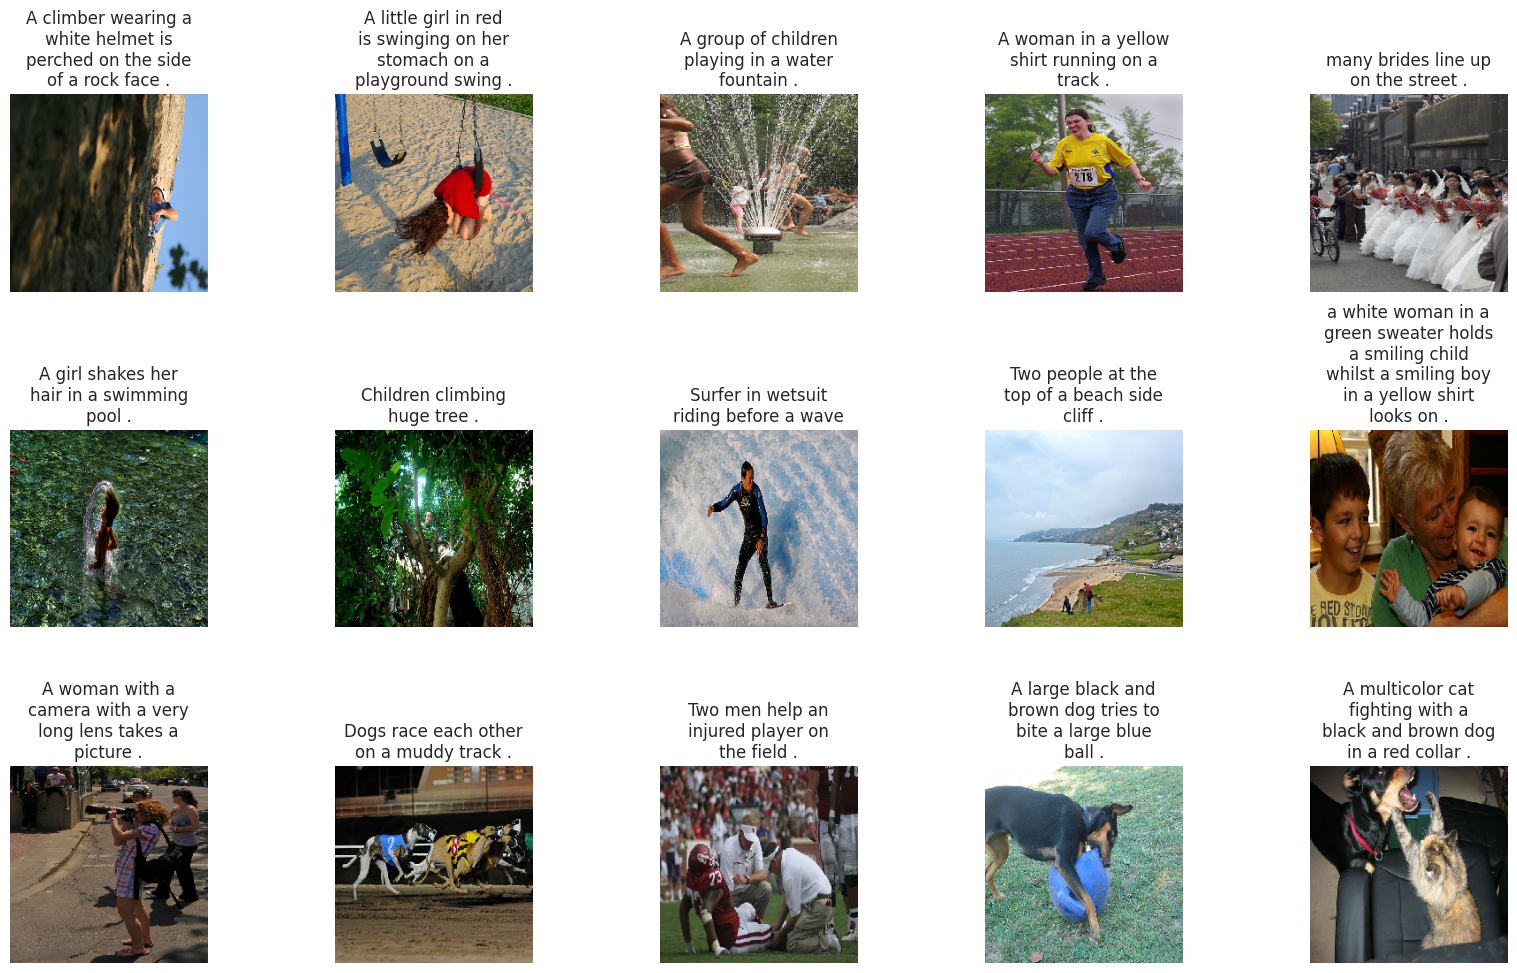

In [9]:
display_images(data.sample(15), 15)


# Preprocessing

## Captions preparation

In [10]:
import re 

def text_preprocessing(data):
    data['caption'] = to_lowercase(data['caption'])
    data['caption'] = exclude_special_characters(data['caption'])
    data['caption'] = remove_extra_whitespaces(data['caption'])
    data['caption'] = remove_single_characters(data['caption'])
    data['caption'] = add_start_end_tokens(data['caption'])
    return data

def to_lowercase(captions):
  return captions.apply(lambda x: x.lower())

def exclude_special_characters(captions):
  return captions.apply(lambda x: re.sub(r"[^A-Za-z ]", "", x))

def remove_extra_whitespaces(captions):
  return captions.apply(lambda x: re.sub("\s{2,}", " ", x.strip()))

def remove_single_characters(captions):
  return captions.apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

def add_start_end_tokens(captions):
  return "startseq " + captions + " endseq"


In [11]:
captions = text_preprocessing(data)['caption'].tolist()
captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## Tokenization
- Reprsent each word as one hot encoding vector
- Calculate vocabulary size
- Calculate maximum sentence length

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in captions)
  

print(f'{captions[1]} -> {tokenizer.texts_to_sequences([captions[1]])[0]}')
print(f'{captions[2]} -> {tokenizer.texts_to_sequences([captions[2]])[0]}')

startseq girl going into wooden building endseq -> [1, 18, 312, 63, 192, 116, 2]
startseq little girl climbing into wooden playhouse endseq -> [1, 39, 18, 118, 63, 192, 2422, 2]


## Define train and test datasets

*   90% of all data is used for training
* 10% of training dataset is used for validation



In [13]:
def get_unique_images(data):
  return data['image'].unique().tolist()

def train_test_split(images, train_size):
  split_idx = round(train_size * len(images))

  return images[:split_idx], images[split_idx:]

def get_image_and_captions(data, images):
  return data[data['image'].isin(images)]

images = get_unique_images(data)
train_images, test_images = train_test_split(images, 0.9) 
train_images, val_images = train_test_split(train_images, 0.85)


train = get_image_and_captions(data, train_images)
validation = get_image_and_captions(data, val_images)
test = get_image_and_captions(data, test_images)

# Encoder
- use VGG19 as encoder part
- remove last 2 layers of VGG19 trained on `imagenet` dataset

In [17]:
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.models import Model


cnn = ResNet101(include_top=True, weights='imagenet')
encoder = Model(inputs=cnn.input, outputs=cnn.layers[-2].output)

## Extract features from images 

- normalization and color channel reordering


In [19]:
from tqdm import tqdm
import os

INPUT_SIZE = 224
FEATURE_SIZE = 2048
features = {}
for image_name in tqdm(data['image'].unique().tolist()):
    image = load_img(
        os.path.join(image_path, image_name),
        target_size=(INPUT_SIZE, INPUT_SIZE)
        )
    image = img_to_array(image)
    image = preprocess_input(image)

    image = np.expand_dims(image, axis=0)
    feature = encoder.predict(image, verbose=0)
    features[image_name] = feature

100%|██████████| 8091/8091 [10:43<00:00, 12.58it/s]


In [22]:
features[images[0]].shape
FEATURE_SIZE = 2048


In [23]:
import pickle

with open('features.pkl', 'wb') as f: 
    pickle.dump(features, f) 

with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

## Define Data generator
 - Create batches of data during training process
  - Each batch is in form of (X = input_data, y = target_data)
 - The inputs are image embeddings and their corresonding caption text embeddings
 - Add padding to caption embeddings

In [24]:
from tensorflow.keras.utils import Sequence, to_categorical, pad_sequences

class DataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)    

        return (X1, X2), y
    
    def __get_data(self, batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [25]:
train_generator = DataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=256,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
    )

validation_generator = DataGenerator(
    df=validation,
    X_col='image',
    y_col='caption',
    batch_size=256,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
    )

# Model

## Architecture

In [26]:
from tensorflow.keras.layers import Input, Dropout, Dense, Reshape, Embedding, concatenate, LSTM, add


image_feature_input = Input(shape=(FEATURE_SIZE,))
caption_embedding_input = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(image_feature_input)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)


sentence_features = Embedding(vocab_size, 256, mask_zero=False)(caption_embedding_input)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[image_feature_input, caption_embedding_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

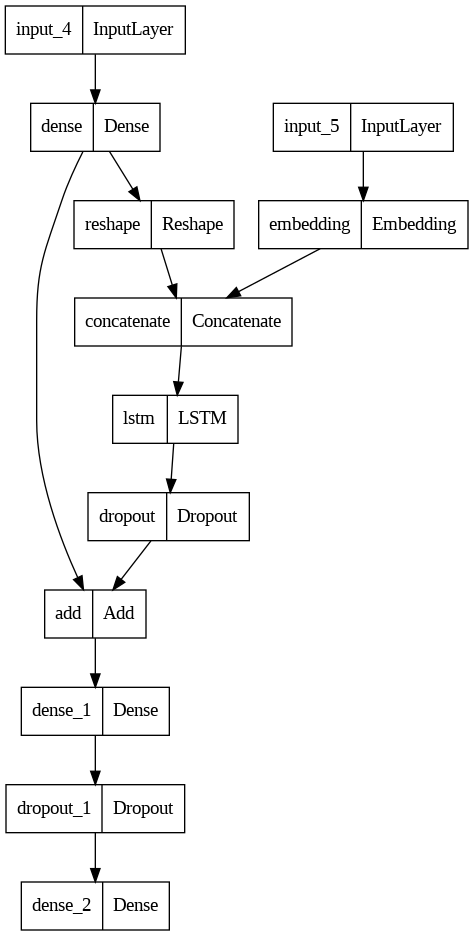

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(caption_model)

In [28]:
caption_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

## Training

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = 'model_vgg19.h5'

checkpoint = ModelCheckpoint(
    model_name,
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    patience = 5, 
    verbose = 1, 
    restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='loss', 
    patience=3, 
    verbose=1, 
    factor=0.2, 
    min_lr=0.00000001)

In [30]:
history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
    )

Epoch 1/50
114/114 [==============================] - ETA: 0s - loss: 5.8635
Epoch 1: val_loss improved from inf to 5.14472, saving model to model_vgg19.h5
114/114 [==============================] - 176s 1s/step - loss: 5.8635 - val_loss: 5.1447 - lr: 0.0010
Epoch 2/50
114/114 [==============================] - ETA: 0s - loss: 4.7501
Epoch 2: val_loss improved from 5.14472 to 4.44237, saving model to model_vgg19.h5
114/114 [==============================] - 44s 383ms/step - loss: 4.7501 - val_loss: 4.4424 - lr: 0.0010
Epoch 3/50
114/114 [==============================] - ETA: 0s - loss: 4.2538
Epoch 3: val_loss improved from 4.44237 to 4.19185, saving model to model_vgg19.h5
114/114 [==============================] - 43s 376ms/step - loss: 4.2538 - val_loss: 4.1919 - lr: 0.0010
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 4.0199
Epoch 4: val_loss improved from 4.19185 to 4.08413, saving model to model_vgg19.h5
114/114 [==============================] - 43s 379m

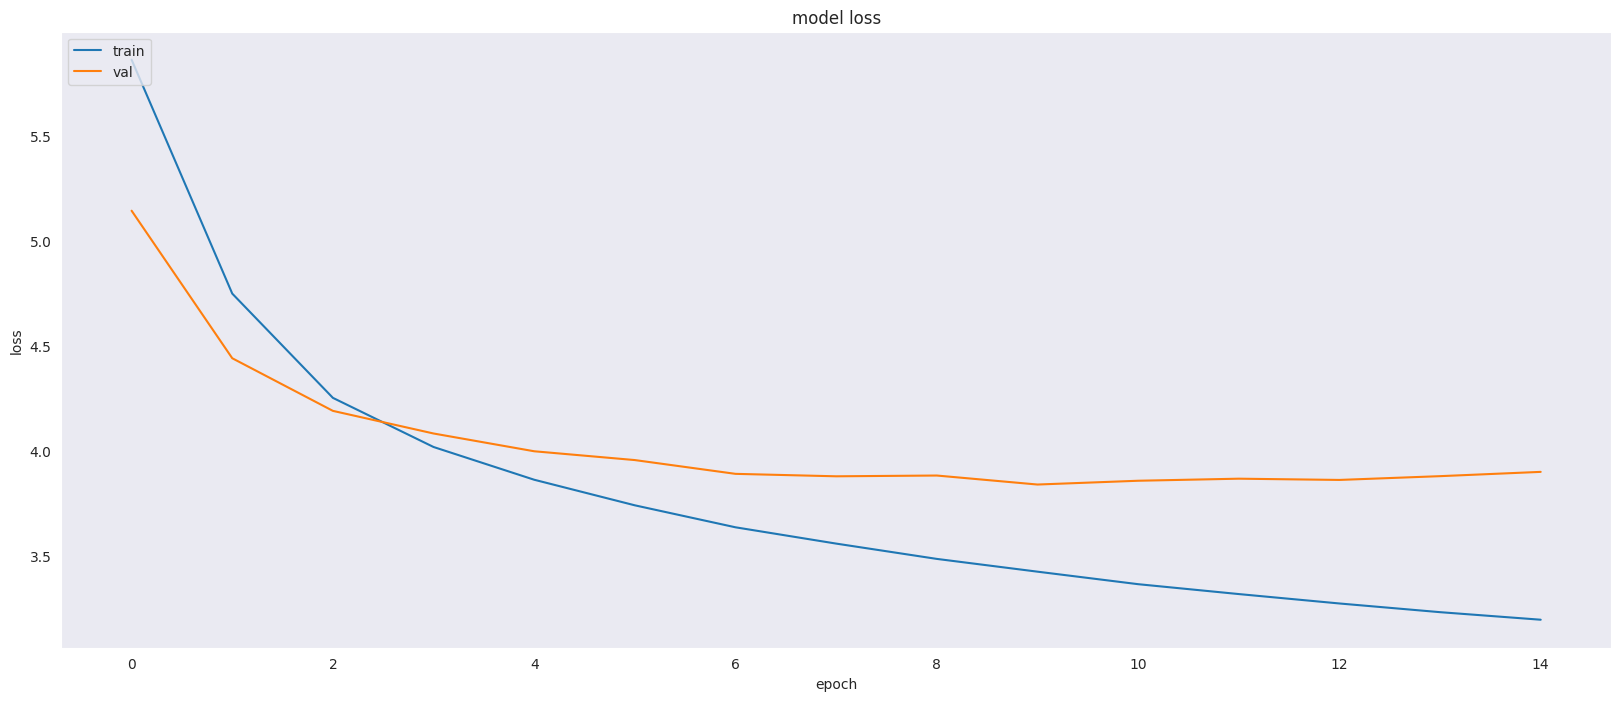

In [31]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# Inference
- Pass embedding of `startseq` and image feature to model 
- Generate words until `endseq` is generated

In [32]:
def idx_to_word(integer, tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [34]:
test = test.sample(15)
temp_df = pd.DataFrame()

for index,record in test.iterrows():
  temp_df = temp_df.append(test.loc[test['image'] == record["image"]])



temp_df = temp_df.reset_index(drop=True)
test = temp_df

In [35]:
for index,record in test.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    test.loc[index,'generated_caption'] = caption

1/1 [==============================] - 0s 18ms/step


# Calculate BLEU metric

In [36]:
import nltk
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction

for index,record in test.iterrows():
  image = record['image']
  captions =  test.loc[test['image'] == image, 'caption']\
              .apply(lambda caption : caption.split()[1:-1])\
              .to_list()

  bleu_score = bleu.sentence_bleu(
      captions, 
      record['generated_caption'].split()[1:-1],  
      smoothing_function=SmoothingFunction().method1) * 100
  test.loc[index,'bleu'] = bleu_score



In [44]:
print(test['bleu'].mean())
test = test.sort_values('bleu', ascending=False)

3.568857040576083


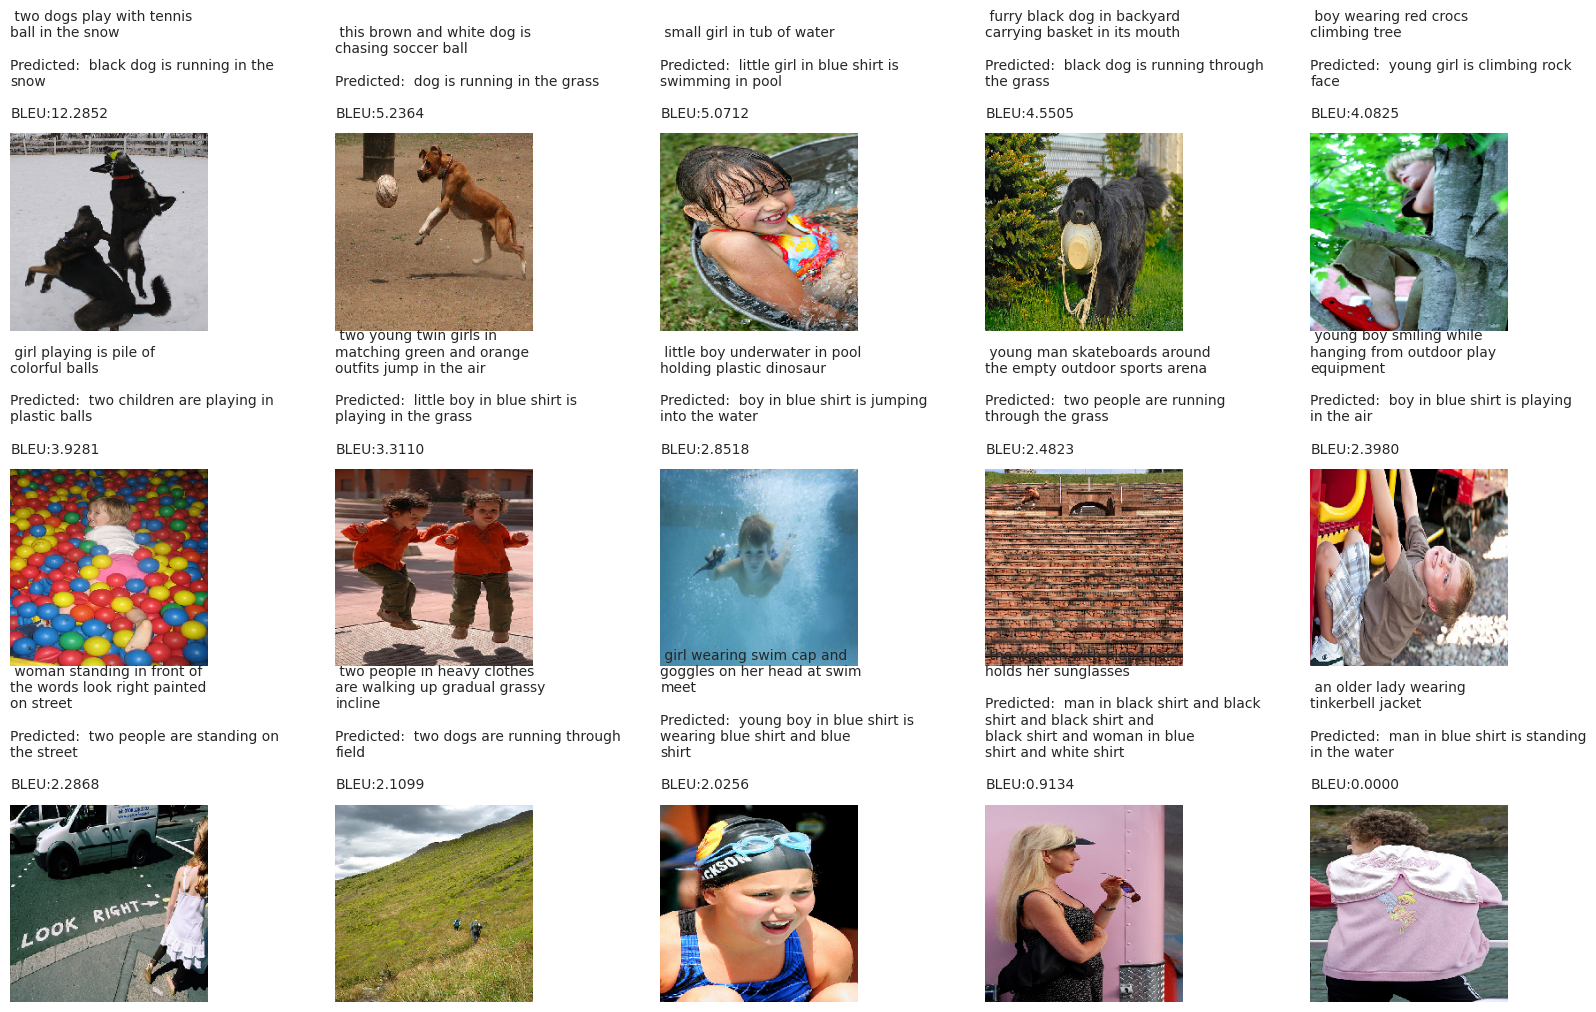

In [45]:
display_results(test, test.shape[0])